# SVM Model

In this notebook, we will train dataset using SVM model. We will first look into the dataset (Data Analysis), try different combinations of hyperparameter using GridSearchCV, and some sanity check. 

## Section 1 - Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
data = pd.read_csv('sign_mnist_train.csv')
data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [3]:
y_train = data['label']
X_train = data.drop(columns = 'label')

### Check if there is any N/A value

In [4]:
data.isna().any().sum()

0

### Check distribution of labels

In [5]:
column_val = 'pixel{value}'
for i in range(1, 785):
    if (data[column_val.format(value=i)] < 0).any() or (data[column_val.format(value=i)] > 255).any():
        print("Unexpected value encountered in pixel column {value}".format(value=i))

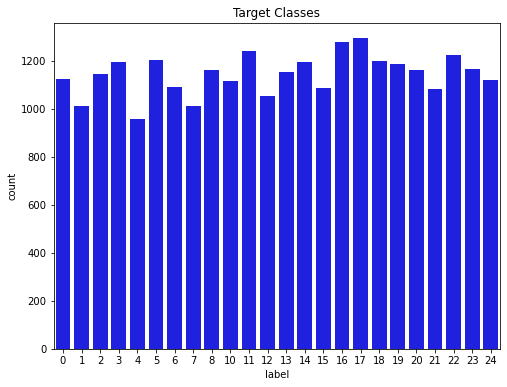

In [6]:
plt.figure(figsize = (8,6))
sns.countplot(x = data['label'], color = 'b')
plt.title('Target Classes')
plt.show()

As we can see the graph above, we can see that there are roughly same amount of labels in the train dataset. Also, we don't see any corrupted values like np.na() or non-integer values in our dataset. That being said, our dataset is well-collected and maintained.

### Simple GridSearchCV (for checking data normalization)

We will run a simple GridSearchCV using SVM to check the data normalization. The reason is because GridSearchCV will break the train data into k number of folds, and use one fold as a validation test. Since it breaks down the train dataset, it allows us to solely test on train dataset as well as increase the efficiency of runtime. 

In [7]:
# Prerequisite
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [15]:
model = SVC(random_state=42)
p_grid = {'C': [0.01],
          'kernel': ['linear', 'poly', 'rbf']}
clf1 = GridSearchCV(estimator=model, param_grid=p_grid, verbose=3)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............C=0.01, kernel=linear;, score=1.000 total time=  36.8s
[CV 2/5] END .............C=0.01, kernel=linear;, score=1.000 total time=  37.6s
[CV 3/5] END .............C=0.01, kernel=linear;, score=1.000 total time=  49.3s
[CV 4/5] END .............C=0.01, kernel=linear;, score=1.000 total time=  39.8s
[CV 5/5] END .............C=0.01, kernel=linear;, score=1.000 total time=  35.0s
[CV 1/5] END ...............C=0.01, kernel=poly;, score=1.000 total time=  47.5s
[CV 2/5] END ...............C=0.01, kernel=poly;, score=1.000 total time= 1.3min
[CV 3/5] END ...............C=0.01, kernel=poly;, score=1.000 total time=  59.1s
[CV 4/5] END ...............C=0.01, kernel=poly;, score=1.000 total time= 1.0min
[CV 5/5] END ...............C=0.01, kernel=poly;, score=1.000 total time=  50.7s
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.356 total time= 9.3min
[CV 2/5] END ................C=0.01, kernel=rbf;,

From the GridSearchCV with regularization parameter of 0.01 (and tested onto different kernel types), we see the validation score of 1.0 for linear and poly kernel in contrast to rbf kernel which shows average score of 0.35. This tells us that our data might be too-normalized so that the train dataset's same label dataset are equal to each other. We can test this claim by using low-neighbor KNN. That way, KNN acts like linear kernel of SVM. If we see the same if not really close to the score of 1, then our claim is true.

On the other hand, we see the SVM kernel type "RBF" is performing drastically worse than other kernels. That can possibly mean that the gamma type of RBF setting is not accurate / relevant to our dataset. Let's test several different types of gamma value to find optimal gamma value.

### Claim Test - Low neighbor of K-NN

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

rf = KFold(n_splits=2, shuffle=True, random_state=42)

model = KNeighborsClassifier()
p_grid = {'n_neighbors':[1,2,3,5,10]}
clf1 = GridSearchCV(estimator=model, param_grid=p_grid, cv=rf, verbose=3)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END .....................n_neighbors=1;, score=0.997 total time=   4.6s
[CV 2/2] END .....................n_neighbors=1;, score=0.998 total time=   3.7s
[CV 1/2] END .....................n_neighbors=2;, score=0.993 total time=   4.0s
[CV 2/2] END .....................n_neighbors=2;, score=0.994 total time=   4.3s
[CV 1/2] END .....................n_neighbors=3;, score=0.992 total time=   5.1s
[CV 2/2] END .....................n_neighbors=3;, score=0.994 total time=   4.2s
[CV 1/2] END .....................n_neighbors=5;, score=0.988 total time=   5.5s
[CV 2/2] END .....................n_neighbors=5;, score=0.987 total time=   4.5s
[CV 1/2] END ....................n_neighbors=10;, score=0.967 total time=   5.0s
[CV 2/2] END ....................n_neighbors=10;, score=0.971 total time=   4.5s
{'mean_fit_time': array([0.08092296, 0.05262494, 0.05003464, 0.05487835, 0.05060446]), 'std_fit_time': array([0.02823985, 0.001036

As we can see, the values are really close to 1, thus our claim is true. 

#### Claim Test - different Gamma value for RBF Kernel

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

model = SVC(random_state=42)
p_grid = {'gamma': ['scale', 'auto', 0.01, 0.05, 0.1, 0.5, 1],
          'kernel': ['rbf']}
clf1 = GridSearchCV(estimator=model, param_grid=p_grid, verbose=3)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...........gamma=scale, kernel=rbf;, score=1.000 total time= 1.5min
[CV 2/5] END ...........gamma=scale, kernel=rbf;, score=1.000 total time= 1.3min
[CV 3/5] END ...........gamma=scale, kernel=rbf;, score=1.000 total time= 1.5min
[CV 4/5] END ...........gamma=scale, kernel=rbf;, score=1.000 total time= 1.4min
[CV 5/5] END ...........gamma=scale, kernel=rbf;, score=1.000 total time= 1.5min
[CV 1/5] END ............gamma=auto, kernel=rbf;, score=0.228 total time= 7.9min
[CV 2/5] END ............gamma=auto, kernel=rbf;, score=0.223 total time= 7.6min
[CV 3/5] END ............gamma=auto, kernel=rbf;, score=0.225 total time= 7.7min
[CV 4/5] END ............gamma=auto, kernel=rbf;, score=0.222 total time= 7.4min
[CV 5/5] END ............gamma=auto, kernel=rbf;, score=0.230 total time= 8.0min
[CV 1/5] END ............gamma=0.01, kernel=rbf;, score=0.114 total time= 8.3min
[CV 2/5] END ............gamma=0.01, kernel=rbf;,

From the above GridSearchCV that search through all possibilities of gamma values for RBF kernel, we see that the gamma kernel of 'Scale' (which is equivalent to 1 / (n_features * X.var()) (more in https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)) performs just like other kernels. Therfore, let's restrict kernel gamma to scale.

## Section 2 - Data Augmentation

In order to make the model more suitable for real-world examples (rather than lab-recorded dataset), we need to perform data augmentation to artificially create noise inside the dataset. One way to perform that is to reduce the dimension of the dataset (called PCA).

#### PCA (Principal Component Analysis)

PCA is unsupervised machine-learning algorithm where it takes the dataset and reduce the dimensionality of the dataset  (https://en.wikipedia.org/wiki/Principal_component_analysis). We will then use GridSearchCV with pipeline to test PCA and SVM at the same time.

#### Small test - PCA with linear kernel SVM

From previous test runs (outside this notebook), somehow it takes forever to compile when PCA is used with Linear kernel. Here is the example:

In [ ]:
# We are setting n_components to different areas of possibility thus check how drastically changes the time / accuracy of dataset.
p_grid = {
    'pca__n_components': [700, 300, 100, 50]
}
pipe = Pipeline([('pca', PCA(random_state=42)), ('svc', SVC(C=0.01, kernel='linear', random_state=42))]) 
clf1 = GridSearchCV(estimator=pipe, param_grid=p_grid, verbose=3, n_jobs=-1)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
p_grid = {
    'pca__n_components': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
    'svc__C': [0.01], # Since we are focusing on which component value is optimal, we are not going to change the regularization value.
    'svc__kernel': ['linear', 'poly']}
pipe = Pipeline([('pca', PCA(random_state=42)), ('svc', SVC(random_state=42))])
clf1 = GridSearchCV(estimator=pipe, param_grid=p_grid, verbose=3, n_jobs=-1)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
# Testing PCA for 'RBF' kernel
p_grid = {
    'pca__n_components': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
    'svc__C': [0.01], # Since we are focusing on which component value is optimal, we are not going to change the regularization value.
    'svc__kernel': ['rbf'],
    'svc__gamma': ['scale']}
pipe = Pipeline([('pca', PCA(random_state=42)), ('svc', SVC(random_state=42))])
clf1 = GridSearchCV(estimator=pipe, param_grid=p_grid, verbose=3, n_jobs=-1)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)

In [ ]:
pca = PCA()

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    clf1.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)

(Write analysis here)

## With StandardScaler

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(C=0.01, kernel='linear', random_state=42))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8068878973786949

## With PCA and StandardScaler

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Chose n_components as 35 since sign language contains 35 distinct letter signs
pipe = Pipeline([('scaler', StandardScaler()),('PCA', PCA(n_components=35)), ('svc', SVC(C=0.01, kernel='linear', random_state=42))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8066090351366425

## With Kfold and GridSearchCV

Somehow, we see overfitting. I don't have a clue to make claim of this issue (most likely just small dataset making overfitting)

## Custom Hyperparameter Selection

In [ ]:
import time
result = {
    'C': [],
    'Kernel': [],
    'Score': [],
    'Time': []
}

C = [0.01, 0.05, 0.1, 0.5, 1, 10]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

for c in C:
    for k in kernel:
        start = time.time()
        model = SVC(C=c, kernel=k, random_state=42).fit(X_train, y_train)
        score = model.score(X_test, y_test)
        end = time.time()
        print("Time Elapsed: ", end-start)
        result['C'].append(c)
        result['Kernel'].append(k)
        result['Score'].append(score)
        result['Time'].append((end-start))

result

Time Elapsed:  38.81698489189148
Time Elapsed:  72.55560040473938
Time Elapsed:  786.5751214027405
Time Elapsed:  812.8502168655396
Time Elapsed:  52.03745412826538
Time Elapsed:  37.626795530319214
Time Elapsed:  471.2527973651886
Time Elapsed:  812.1136202812195
Time Elapsed:  39.940268993377686
Time Elapsed:  27.383901834487915
Time Elapsed:  342.4818193912506
Time Elapsed:  840.290323972702
Time Elapsed:  36.873708963394165
Time Elapsed:  30.165858030319214
Time Elapsed:  195.7655382156372
Time Elapsed:  966.0575969219208
Time Elapsed:  50.02760887145996
Time Elapsed:  32.56570553779602
Time Elapsed:  135.58537697792053
Time Elapsed:  879.2025561332703
Time Elapsed:  41.81144642829895
Time Elapsed:  31.157321453094482


### Show which model did best

In [14]:
index = 0
score = 0

for i in range(len(result['Score'])):
    if result['Score'][i] > score:
        score = result['Score'][i]
        index = i

print("Best Model: ")
print("C: ", result['C'][index])
print("Kernel: ", result['Kernel'][index])
print("Score: ", result['Score'][index])
print("Elapsed Time: ", result['Time'][index])

Best Model: 
C:  1
Kernel:  rbf
Score:  0.8418851087562744
Elapsed Time:  135.58537697792053


## PCA with different values (with best model)

In [16]:
# n_components = 50
pipe = Pipeline([('PCA', PCA(n_components=50)), ('svc', SVC(C=1, kernel='rbf', random_state=42))])
pipe.fit(X_train, y_train)
print("N_Components of 50: ", pipe.score(X_test, y_test))

# n_components = 40
pipe = Pipeline([('PCA', PCA(n_components=40)), ('svc', SVC(C=1, kernel='rbf', random_state=42))])
pipe.fit(X_train, y_train)
print("N_Components of 40: ", pipe.score(X_test, y_test))

# n_components = 30
pipe = Pipeline([('PCA', PCA(n_components=30)), ('svc', SVC(C=1, kernel='rbf', random_state=42))])
pipe.fit(X_train, y_train)
print("N_Components of 30: ", pipe.score(X_test, y_test))

# n_components = 20
pipe = Pipeline([('PCA', PCA(n_components=20)), ('svc', SVC(C=1, kernel='rbf', random_state=42))])
pipe.fit(X_train, y_train)
print("N_Components of 20: ", pipe.score(X_test, y_test))

N_Components of 50:  0.8721416620189626
N_Components of 40:  0.8711656441717791
N_Components of 30:  0.8621026213050753
N_Components of 20:  0.8297546012269938


In [17]:
# n_components = 10
pipe = Pipeline([('PCA', PCA(n_components=10)), ('svc', SVC(C=1, kernel='rbf', random_state=42))])
pipe.fit(X_train, y_train)
print("N_Components of 20: ", pipe.score(X_test, y_test))

N_Components of 20:  0.6755437813720022


## Questions to Ask:

### Should we normalize the dataset
### Is RBF style correct to our dataset style
### Anything I should do for model selection / optimization of model?

## From TA - Try smaller size when using GridSearchCV

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

X_train_small = X_train[0:5000] # 5001 elements
y_train_small = y_train[0:5000]
X_test_small = X_test[0:5000]
y_test_small = y_test[0:5000]

model = SVC(random_state=42)
p_grid = {'C': [0.01],
          'kernel': ['linear', 'poly', 'rbf']}
clf1 = GridSearchCV(estimator=model, param_grid=p_grid, verbose=3)
clf1.fit(X_train_small, y_train_small)

# View the Grid Search CV Results
print(clf1.cv_results_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............C=0.01, kernel=linear;, score=0.991 total time=   1.8s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.983 total time=   2.4s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.996 total time=   2.1s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.995 total time=   2.3s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.991 total time=   2.3s
[CV 1/5] END ...............C=0.01, kernel=poly;, score=0.975 total time=   2.0s
[CV 2/5] END ...............C=0.01, kernel=poly;, score=0.958 total time=   3.2s
[CV 3/5] END ...............C=0.01, kernel=poly;, score=0.965 total time=   2.4s
[CV 4/5] END ...............C=0.01, kernel=poly;, score=0.962 total time=   2.0s
[CV 5/5] END ...............C=0.01, kernel=poly;, score=0.970 total time=   2.7s
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.048 total time=   7.1s
[CV 2/5] END ................C=0.01, kernel=rbf;,

In [11]:
# Around 10000 elements
X_train_small = X_train[0:10000]
y_train_small = y_train[0:10000]
X_test_small = X_test[0:10000]
y_test_small = y_test[0:10000]

model = SVC(random_state=42)
p_grid = {'C': [0.01],
          'kernel': ['linear', 'poly', 'rbf']}
clf1 = GridSearchCV(estimator=model, param_grid=p_grid, verbose=3)
clf1.fit(X_train_small, y_train_small)

# View the Grid Search CV Results
print(clf1.cv_results_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............C=0.01, kernel=linear;, score=1.000 total time=   6.8s
[CV 2/5] END .............C=0.01, kernel=linear;, score=1.000 total time=   5.4s
[CV 3/5] END .............C=0.01, kernel=linear;, score=1.000 total time=   5.0s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.999 total time=   4.8s
[CV 5/5] END .............C=0.01, kernel=linear;, score=1.000 total time=   4.3s
[CV 1/5] END ...............C=0.01, kernel=poly;, score=0.996 total time=   6.6s
[CV 2/5] END ...............C=0.01, kernel=poly;, score=0.997 total time=   6.4s
[CV 3/5] END ...............C=0.01, kernel=poly;, score=1.000 total time=   6.3s
[CV 4/5] END ...............C=0.01, kernel=poly;, score=0.998 total time=   6.2s
[CV 5/5] END ...............C=0.01, kernel=poly;, score=0.995 total time=   6.2s
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.083 total time=  31.3s
[CV 2/5] END ................C=0.01, kernel=rbf;,

## What if we increase the fold value (say to 10, 20)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

rf = KFold(n_splits=20, shuffle=True, random_state=42)

model = SVC(random_state=42)
p_grid = {'C': [0.01],
          'kernel': ['linear', 'poly', 'rbf']}
clf1 = GridSearchCV(estimator=model, param_grid=p_grid, cv=rf, verbose=3)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)

Fitting 20 folds for each of 3 candidates, totalling 60 fits
[CV 1/20] END ............C=0.01, kernel=linear;, score=1.000 total time=  30.1s
[CV 2/20] END ............C=0.01, kernel=linear;, score=1.000 total time=  37.4s
[CV 3/20] END ............C=0.01, kernel=linear;, score=1.000 total time=  32.2s
[CV 4/20] END ............C=0.01, kernel=linear;, score=1.000 total time=  28.5s
[CV 5/20] END ............C=0.01, kernel=linear;, score=1.000 total time=  32.0s
[CV 6/20] END ............C=0.01, kernel=linear;, score=1.000 total time=  32.3s
[CV 7/20] END ............C=0.01, kernel=linear;, score=1.000 total time=  30.7s
[CV 8/20] END ............C=0.01, kernel=linear;, score=1.000 total time=  30.1s
[CV 9/20] END ............C=0.01, kernel=linear;, score=1.000 total time=  27.5s
[CV 10/20] END ...........C=0.01, kernel=linear;, score=1.000 total time=  27.9s
[CV 11/20] END ...........C=0.01, kernel=linear;, score=1.000 total time=  39.1s
[CV 12/20] END ...........C=0.01, kernel=linear;

## KFold/GridSearchCV with less fold (to decrease complexity of model)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

rf = KFold(n_splits=2, shuffle=True, random_state=42)

model = SVC(random_state=42)
p_grid = {'C': [0.01],
          'kernel': ['linear', 'poly', 'rbf']}
clf1 = GridSearchCV(estimator=model, param_grid=p_grid, cv=rf, verbose=3)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END .............C=0.01, kernel=linear;, score=1.000 total time=  16.1s
[CV 2/2] END .............C=0.01, kernel=linear;, score=1.000 total time=  15.2s
[CV 1/2] END ...............C=0.01, kernel=poly;, score=1.000 total time=  28.3s
[CV 2/2] END ...............C=0.01, kernel=poly;, score=1.000 total time=  28.4s


## KFold/GridSearchCV with high regularization value with less fold

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

rf = KFold(n_splits=2, shuffle=True, random_state=42)

model = SVC(random_state=42)
p_grid = {'C': [1, 10, 25, 100],
          'kernel': ['linear', 'poly']}
clf1 = GridSearchCV(estimator=model, param_grid=p_grid, cv=rf, verbose=3)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END ................C=1, kernel=linear;, score=1.000 total time=  16.5s
[CV 2/2] END ................C=1, kernel=linear;, score=1.000 total time=  16.2s
[CV 1/2] END ..................C=1, kernel=poly;, score=1.000 total time=   9.6s
[CV 2/2] END ..................C=1, kernel=poly;, score=1.000 total time=   9.3s
[CV 1/2] END ...............C=10, kernel=linear;, score=1.000 total time=  16.2s
[CV 2/2] END ...............C=10, kernel=linear;, score=1.000 total time=  16.2s
[CV 1/2] END .................C=10, kernel=poly;, score=1.000 total time=   9.6s
[CV 2/2] END .................C=10, kernel=poly;, score=1.000 total time=   9.3s
[CV 1/2] END ...............C=25, kernel=linear;, score=1.000 total time=  16.2s
[CV 2/2] END ...............C=25, kernel=linear;, score=1.000 total time=  16.0s
[CV 1/2] END .................C=25, kernel=poly;, score=1.000 total time=   9.6s
[CV 2/2] END .................C=25, kernel=poly;,

## KNN with n_neighbors of 1,2,3,5, and 10

## SVM with RBF low scale (Using GridSearchCV)

## What if data is different (train and test dataset is somehow different)

In [25]:
from sklearn.model_selection import train_test_split

combined_data = pd.concat([data, data2]).sample(frac=1)
y = combined_data['label']
X = combined_data.drop(columns = 'label')

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

SVC(C=0.01, kernel='linear', random_state=42).fit(X_train_1, y_train_1).score(X_test_1, y_test_1)

1.0

Original Value (Without combining train/test dataset) = 0.7816508644729504